<a href="https://colab.research.google.com/github/helonayala/bah/blob/main/BallAndHoop_NARXANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [ ]:
!pip install sysidentpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sysidentpy.metrics import mean_squared_error

In [ ]:
!ls sample_data/

anscombe.json		      malha_fechada2.mat     README.md
california_housing_test.csv   mnist_test.csv	     seqDegrausFixo2.mat
california_housing_train.csv  mnist_train_small.csv  seqDegrausRand2.mat


#Dados de entrada e saída

##Reprodutibilidade

In [ ]:
rseed = 42
np.random.seed(rseed)
tf.keras.utils.set_random_seed(rseed)
tf.config.experimental.enable_op_determinism()

##Importando os Dados e Normalização

###Degrau aleatório

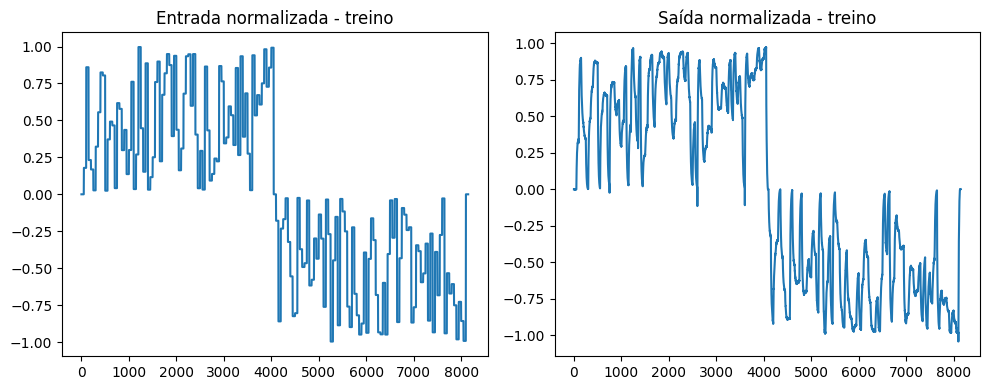

In [ ]:
mat1 = loadmat('/content/sample_data/seqDegrausRand2.mat')
df1 = pd.DataFrame(mat1['u'], columns=['u'])
df1['y'] = mat1['y']

y_train= mat1['y']
u_train = mat1['u']
n_train = len(y_train)

#Normalização da saída entre -1 e 1
x_train_norm = u_train.flatten()
y_train_norm = (y_train/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_train_norm)
ax[0].set_title('Entrada normalizada - treino')

ax[1].plot(y_train_norm)
ax[1].set_title('Saída normalizada - treino')

plt.tight_layout()
plt.show()

###Degrau Fixo

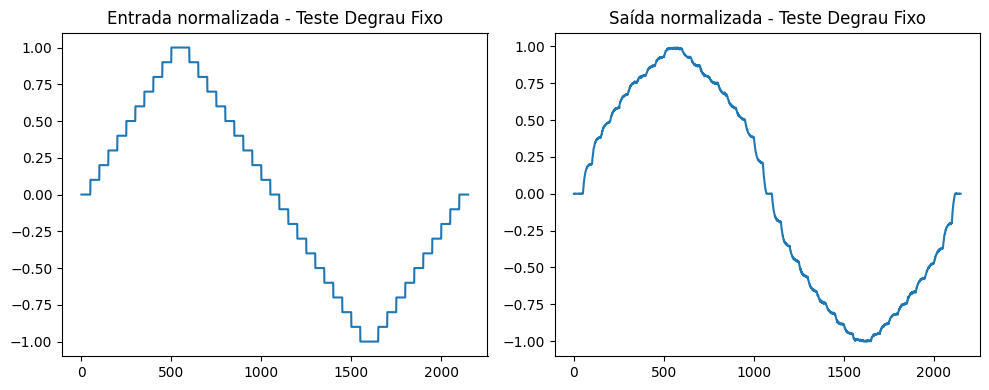

In [ ]:
mat2 = loadmat('/content/sample_data/seqDegrausFixo2.mat')
df2 = pd.DataFrame(mat2['u'], columns=['u'])
df2['y'] = mat2['y']

y_test1 = mat2['y']
u_test1 = mat2['u']
n_test1 = len(y_test1)

#Normalização da saída
x_test1_norm = u_test1.flatten()
y_test1_norm = (y_test1/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_test1_norm)
ax[0].set_title('Entrada normalizada - Teste Degrau Fixo')

ax[1].plot(y_test1_norm)
ax[1].set_title('Saída normalizada - Teste Degrau Fixo')

plt.tight_layout()
plt.show()

###Malha Fechada

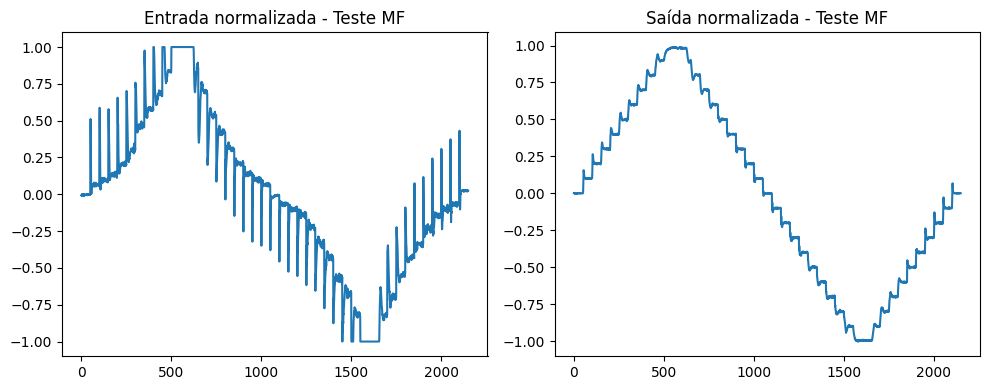

In [ ]:
mat3 = loadmat('/content/sample_data/malha_fechada2.mat')
df3 = pd.DataFrame(mat3['u'], columns=['u'])
df3['y'] = mat3['y']

y_test2= mat3['y']
u_test2 = mat3['u']
n_test2 = len(y_test2)

#Normalização dos dados de saída
x_test2_norm = u_test2.flatten()
y_test2_norm = (y_test2/10).flatten()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(x_test2_norm)
ax[0].set_title('Entrada normalizada - Teste MF')

ax[1].plot(y_test2_norm)
ax[1].set_title('Saída normalizada - Teste MF')

plt.tight_layout()
plt.show()

#NARX ANN

##Matriz de regressão

In [ ]:
def matReg(y,u,ny,nu):

    p = np.max((ny,nu)) + 1
    N = len(y)
    Nu = len(u)

    # sanity check
    if N != Nu:
        print('Dimensions of u and y vector are not consistent')
        return (-1,-1)

    # create target vector
    target = y[p-1:N]

    # create regression matrix
    Phi = np.zeros((N-p+1,ny+nu))
    for i in range(ny):
        Phi[:,i]    = y[p-i-2: N - i-1]

    for i in range(nu):
        Phi[:,i+ny] = u[p-i-2: N - i-1]

    return (target, Phi)

##Free run

In [ ]:
def freeRun(model, y, u,ny,nu):
    p = max(ny,nu) + 1
    (N, ) = y.shape

    yhat = np.zeros(N)
    yhat[:p-1] = y[:p-1] # include initial conditions

    for k in range(p,N+1):
        # print(k)
        auxY = np.concatenate((  yhat[(k-p):(k-1)]   ,  (0,)   ),axis=0)
        auxU = np.concatenate((  u   [(k-p):(k-1)]   ,  (0,)   ),axis=0)

        _,fr_input = matReg(auxY,auxU,ny,nu)
        yhat[k-1] = model.predict(fr_input,verbose=0)
    # return only the values that are predictions
    # (remove the initial conditions)
    return yhat[-(N-p+1):]

In [ ]:
ny = 3 #lags y (variar de 2 a 5)
nu = 3 # model orders (variar de 2 a 5)

ye = y_train_norm
ue = x_train_norm
yt1 = y_test1_norm
ut1 = x_test1_norm
yt2 = y_test2_norm
ut2 = x_test2_norm
(Ye,Phie) = matReg(ye,ue,ny,nu) #degrau aleatório
(Yt1,Phit1) = matReg(yt1,ut1,ny,nu) #degrau fixo
(Yt2,Phit2) = matReg(yt2,ut2,ny,nu) #malha fechada

##Modelo ANN

In [ ]:
_ , ninp = Phie.shape
nout = 1 #neuronio da camada de saída
nneu = 4 #numero de neuronios de cada camada escondida (4, 16, 32)

# model definition
input_ = keras.layers.Input(shape=(ninp,))
hidden1 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal",)(input_)
#hidden2 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden1)
#hidden3 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden2)
#hidden4 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden3)
#hidden5 = keras.layers.Dense(nneu, activation="selu",kernel_initializer="lecun_normal")(hidden4)
output = keras.layers.Dense(nout)(hidden1)

model = keras.models.Model(inputs=[input_],outputs=[output])

optimizer = keras.optimizers.Nadam(learning_rate = 1e-3)

model.compile(loss="mean_squared_error", optimizer=optimizer)

In [ ]:
history = model.fit(Phie, Ye, epochs=3, batch_size = 32)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6960
Epoch 2/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0055
Epoch 3/3
255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045


In [ ]:
# One step ahead
yhat = model.predict(Phie)
yhat1 = model.predict(Phit1)
yhat2 = model.predict(Phit2)

mse = mean_squared_error(ye, yhat)
mse1 = mean_squared_error(yt1, yhat1)
mse2 = mean_squared_error(yt2, yhat2)

R2test1  = r2_score(Yt1, yhat1)
R2test2  = r2_score(Yt2, yhat2)
R2train1 = r2_score(Ye, yhat)

print("\n-------------- One Step Ahead --------------")
print(f"R² Test 1: {R2test1}")
print(f"MSE Test 1: {mse1}")
print(f"R² Test 2: {R2test2}")
print(f"MSE Test 2: {mse2}")
print(f"R² Train: {R2train1}")
print(f"MSE Train: {mse}")

 66/255 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_82']
Received: inputs=Tensor(shape=(32, 6))
  warnings.warn(msg)


255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

-------------- One Step Ahead --------------
R² Test 1: 0.9927343247879622
MSE Test 1: 0.9352666883699517
R² Test 2: 0.9858720208117087
MSE Test 2: 0.7206469417221893
R² Train: 0.9907208545978574
MSE Train: 0.8665375003339776


##Resultados de teste

In [ ]:
y_test_pred1  = freeRun(model,yt1,ut1,ny,nu)

R2test1  = r2_score(Yt1, y_test_pred1)
RMSEtest1 = root_mean_squared_error(Yt1, y_test_pred1)
MAEtest1 = mean_absolute_error(Yt1, y_test_pred1)

print('-------------- Free Run - Degrau Fixo --------------')
print('R2test1 =',R2test1)
print('RMSEtest1 =', RMSEtest1)
print('MAEtest1 =', MAEtest1)

<ipython-input-275-8b697468495c>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[k-1] = model.predict(fr_input,verbose=0)


-------------- Free Run - Degrau Fixo --------------
R2test1 = -8.664884770003788
RMSEtest1 = 2.1284022128145175
MAEtest1 = 1.7907416801832017


In [ ]:
y_test_pred2  = freeRun(model,yt2,ut2,ny,nu)

R2test2  = r2_score(Yt2, y_test_pred2)
RMSEtest2 = root_mean_squared_error(Yt2, y_test_pred2)
MAEtest2 = mean_absolute_error(Yt2, y_test_pred2)

print('-------------- Free Run - Malha Fechada --------------')
print('R2test2 =', R2test2)
print('RMSEtest2 =', RMSEtest2)
print('MAEtest1 =', MAEtest2)

<ipython-input-275-8b697468495c>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yhat[k-1] = model.predict(fr_input,verbose=0)


-------------- Free Run - Malha Fechada --------------
R2test2 = -11.686865059397178
RMSEtest2 = 2.1336298335079174
MAEtest1 = 1.7924890121500936


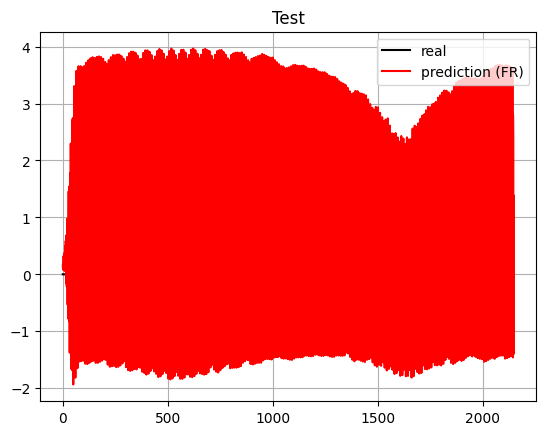

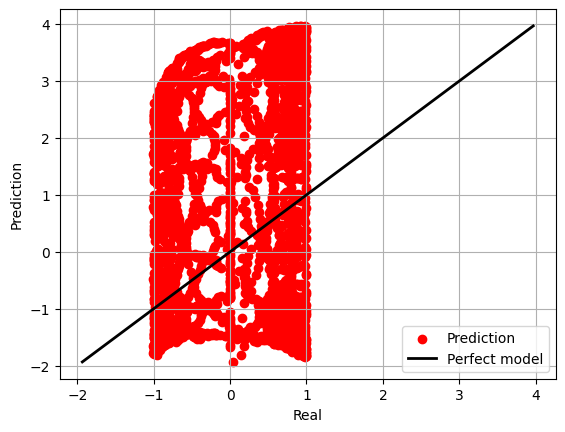

In [ ]:
plt.figure()
plt.plot(Yt1,'k',y_test_pred1,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt1),min(y_test_pred1))
maxY = max(max(Yt1),max(y_test_pred1))
plt.scatter(Yt1,y_test_pred1,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()

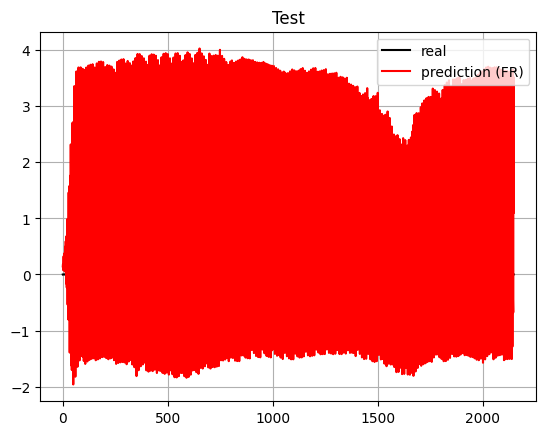

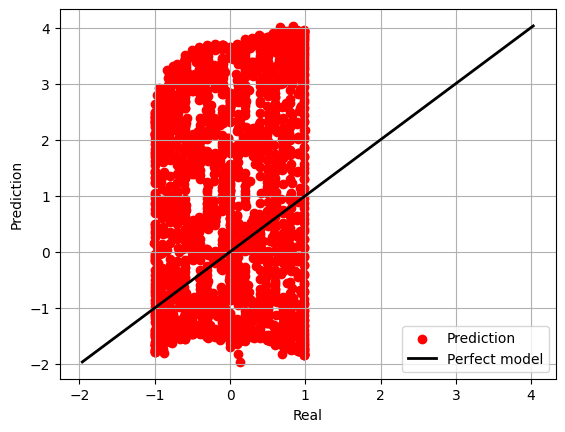

In [ ]:
plt.figure()
plt.plot(Yt2,'k',y_test_pred2,'r')
plt.title('Test')
plt.legend(('real','prediction (FR)'))
plt.grid()
plt.show()

plt.figure()
minY = min(min(Yt2),min(y_test_pred2))
maxY = max(max(Yt2),max(y_test_pred2))
plt.scatter(Yt2,y_test_pred2,c='red',label='Prediction')
plt.plot([minY, maxY], [minY, maxY], color = 'black', linewidth = 2,label='Perfect model')
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.grid()
plt.legend()
plt.show()